In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [2]:
import config as conf
import data_preparation as pr
import features_extract as ex
import features_generator as fg

In [3]:
# DATA PREPARATION
train_events = conf.TRAIN_EVENTS
train_submissions = conf.TRAIN_SUBMISSIONS
test_events = conf.TEST_EVENTS
test_submissions = conf.TEST_SUBMISSIONS

In [4]:
# BASELINE FEATURES
# train_data =pr.data_preparation(train_events, train_submissions)
# test_data = pr.data_preparation(test_events, test_submissions)

In [ ]:
# NEW FEATURES GENERATION
train_data = fg.features_generator(train_events, train_submissions)
test_data = fg.features_generator(test_events, test_submissions)

In [35]:
X_cv = pd.read_csv('/Users/mitya/X_cv.csv')
X_pred = pd.read_csv('/Users/mitya/X_pred.csv')

In [6]:
train_data.columns

Index(['discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct',
       'course_complete', 'd_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1',
       'w_2', 'p_1', 'p_2', 'c_1', 'c_2', 'd_ratio', 'v_ratio', 's_ratio',
       'w_ratio', 'p_ratio', 'c_ratio', 'agg', 'cw_ratio', 'sp_ratio'],
      dtype='object')

In [42]:
# DROP FEATURES
baseline_drop = ['discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct']
ratio_drop = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio']
events_by_days_drop = ['d_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2']
all_new_features_drop = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'd_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2']
custom_drop_v1 = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'agg', 'cw_ratio']
custom_drop_v2 = ['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'discovered', 'viewed', 'started_attempt', 'd_1', 'd_2', 'v_1', 'v_2', 's_1', 's_2', 'w_1', 'w_2', 'p_1', 'p_2', 'c_1', 'c_2']

train_data_copy = train_data.drop(['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio','agg', 'cw_ratio', 'sp_ratio', 'discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct'], axis=1)
test_data_copy = test_data.drop(['d_ratio', 'v_ratio', 's_ratio', 'w_ratio', 'p_ratio', 'c_ratio', 'agg', 'cw_ratio', 'sp_ratio', 'discovered', 'viewed', 'started_attempt', 'wrong', 'passed', 'correct'], axis=1)

In [43]:
test_data_copy.head()

,course_complete,d_1,d_2,v_1,v_2,s_1,s_2,w_1,w_2,p_1,p_2,c_1,c_2
user_id,,,,,,,,,,,,,
4,False,1,0,1,0,0,0,0,0,1,0,0,0
6,False,1,0,1,0,0,0,0,0,1,0,0,0
10,False,2,0,6,0,0,0,0,0,2,0,0,0
12,False,11,0,14,0,4,0,0,0,9,0,1,0
13,False,54,16,70,35,20,15,26,10,53,17,19,10


In [36]:
def drop_features(data, features):
    data = data[features]
    return data

In [37]:
cool_features =['user_id', 'correct_rat_viewed', 'correct__mean', 'correct_rat_started_attempt', 'correct_rat_discovered', 'correct_rat_attempts', 'correct__autocorrelation__lag_0', 'viewed__minimum', 'started_attempt__length', 'correct_rat_passed', 'correct__variance', 'viewed__mean', 'viewed__variance', 'wrong__length', 'passed__length', 'discovered__length']
X_cv = drop_features(X_cv, cool_features)
X_pred = drop_features(X_pred, cool_features)

In [38]:
X_cv.columns

Index(['user_id', 'correct_rat_viewed', 'correct__mean',
       'correct_rat_started_attempt', 'correct_rat_discovered',
       'correct_rat_attempts', 'correct__autocorrelation__lag_0',
       'viewed__minimum', 'started_attempt__length', 'correct_rat_passed',
       'correct__variance', 'viewed__mean', 'viewed__variance',
       'wrong__length', 'passed__length', 'discovered__length'],
      dtype='object')

In [44]:
train_data_copy = train_data_copy.merge(X_cv, on='user_id', how='outer').fillna(0)

In [45]:
test_data_copy = test_data_copy.merge(X_pred, on='user_id', how='outer').fillna(0)

In [61]:
train_data_copy = train_data_copy.drop('user_id', axis=1)
test_data_copy = test_data_copy.drop('user_id', axis=1)

In [62]:
# FEATURES EXTRACTION
X, y = ex.features_extract(train_data_copy)
X_res, _ = ex.features_extract(test_data_copy)

In [63]:
# MODEL VALIDATION

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y)

In [65]:
# Find best params for model
'''
params = {'n_estimators': range(1, 100, 20), 'max_depth': range(1, 20, 10), 'min_samples_split': range(1, 30, 10), 'min_samples_leaf': range(1, 30, 10)}
rf = RandomForestClassifier(class_weight='balanced')
best_rf = GridSearchCV(rf, params, verbose=1, n_jobs=5)
best_rf.fit(X_train, y_train)
best_rf.best_params_
'''

"\nparams = {'n_estimators': range(1, 100, 20), 'max_depth': range(1, 20, 10), 'min_samples_split': range(1, 30, 10), 'min_samples_leaf': range(1, 30, 10)}\nrf = RandomForestClassifier(class_weight='balanced')\nbest_rf = GridSearchCV(rf, params, verbose=1, n_jobs=5)\nbest_rf.fit(X_train, y_train)\nbest_rf.best_params_\n"

In [66]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2,
                            min_samples_leaf=10, min_samples_split=10,
                            class_weight='balanced')

rf.fit(X_train, y_train)
predictions_proba = rf.predict_proba(X_test)[:, 1]
predictions = rf.predict(X_test)

In [67]:
feature_importance_df = pd.DataFrame({'features': list(train_data_copy.columns.drop('course_complete')), 'importance': rf.feature_importances_})

In [68]:
feature_importance_df

,features,importance
0,d_1,0.015250
1,d_2,0.006668
2,v_1,0.014567
3,v_2,0.010015
4,s_1,0.008424
5,s_2,0.002561
6,w_1,0.010342
7,w_2,0.007792
8,p_1,0.015615
9,p_2,0.005909


In [69]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

Log loss = 0.31709
AUC = 0.89405
Average Precision = 0.51607

Using 0.5 as threshold:
Accuracy = 0.82069
Precision = 0.33182
Recall = 0.74112
F1 score = 0.45840

Classification Report
              precision    recall  f1-score   support

       False       0.97      0.83      0.89      1727
        True       0.33      0.74      0.46       197

    accuracy                           0.82      1924
   macro avg       0.65      0.79      0.68      1924
weighted avg       0.90      0.82      0.85      1924



In [70]:
random_forest_cross_val = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(random_forest_cross_val, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.8873585337343484


/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


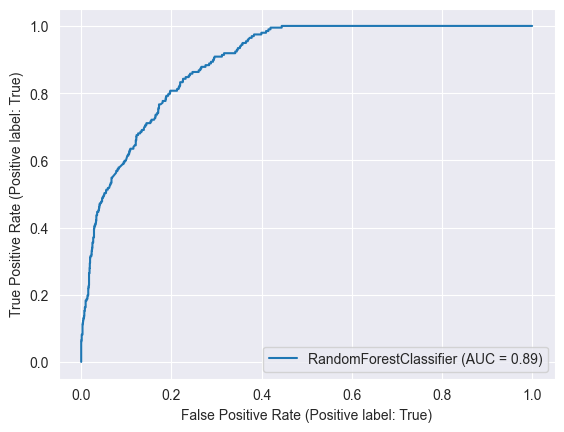

In [71]:
plot_roc_curve(rf, X_test, y_test)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


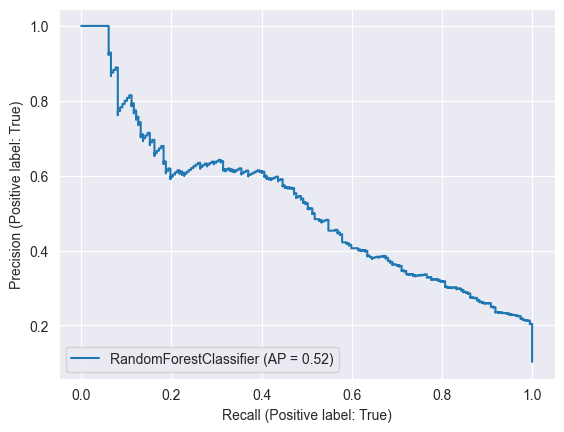

In [72]:
plot_precision_recall_curve(rf, X_test, y_test)
plt.show()

Confusion Matrix


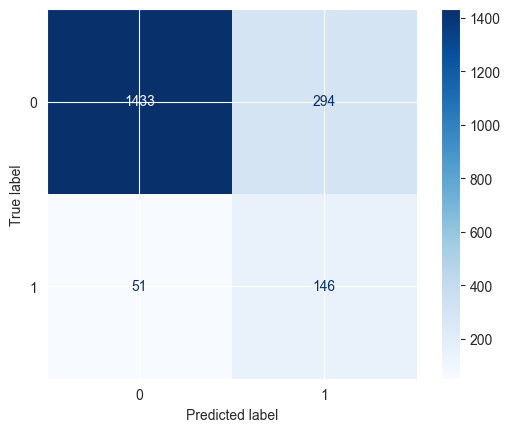

In [73]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [74]:
# PREDICTION
predictions_proba_res = rf.predict_proba(X_res)[:, 1]

In [75]:
# EXPORT DATA
result = pd.concat([pd.Series(test_data.index), pd.Series(predictions_proba_res)], axis=1).rename(columns={0: 'is_gone'}).set_index('user_id')

In [76]:
result.to_csv('/Users/mitya/prediction_res_rf.csv')

In [ ]:
# RESULT
'''
'agg', 'cw_ratio', 'sp_ratio' < Baseline


Baseline:               0.8807418373271483
Discovered, viewed, started_attempt, wrong, passed, correct,
s_1, p_1, c_1:          0.8862945726065735
Wrong, passed, correct, course_complete, d_1, d_2,
v_1, v_2, s_1, s_2:     0.886678096384541
Events by days & ratio: 0.8875785582005356
Ratio:                  0.8885695390587979
Events by days:         0.8906013200243321

predict_2022-11-24_submit_10: 0.894922591019768
'''